Here we provide:

1) Class for simulating measurements over quantum Ising model (based on mpnum library)

2) Variational autoencoder which is able to learn PDF over measurements (quantum tomography)

3) Specially designed VAE which is able to reconstruct structure of inverse RG flow (under development)

We recommend to run this code by using Google Colab

In [1]:
#importing of necessary libraries and modules (recommended to run in Google colab)

!pip install mpnum
import numpy as np
import matplotlib.pyplot as plt
import mpnum as mp
import mpnum.povm as mpp
import functools
import scipy
from mpnum.utils.array_transforms import local_to_global
import os
import pickle
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':24})
rc('xtick', labelsize=24)
rc('ytick', labelsize=24)

from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 81kB 3.2MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Class for data generation.

The class ising_chain provides necessary tools for data generation.

To create object from this class, run: obj = ising_chain(sites, ta, la), where sites is number of spins in a chain, ta and la are parameters of the hamiltonian: $H = \sum_{\langle i j \rangle} -\sigma_z^{i} \sigma_z^{j} - {\rm la}\sum_i \sigma_z^{i} - {\rm ta}\sum_i \sigma_x^{i}$.
We do not recomend to use ${\rm la}\neq 0$ in the current version of code.

To find the ground state of the model, run: obj.gs(). Method gs() does not return anything. It updates ground state into the body of the object. You should run this method first, otherwise other methods do not work.

To calculate two points correlation function, run: c = obj.corr(site1, site2, a, b), where site1 and site2 are numbers of sites which you observe, a and b are one site quantum observables. This method returns value of correlation function: $\langle a_{site1}b_{site2}\rangle$.

To calculate one site mean, run: mean = obj.one_site_mean(site, a), where site is number of site, a is one site quantum observable. This method returns value of one site mean: $\langle a_{site}\rangle$

To sample from POVM induced PDF, run: samples = obj.sample(n), this method returns $n$ samples (np.array with shape = (n, number_of_sites)).

To calculate two points correlation function from samples, run: c = corr_from_samples(samples, site1, site2, a, b). This function works like method corr(), but you need additionally provide samples.

In [0]:
#Pauli matrices
x = np.array([[0, 1], [1, 0]], dtype=np.complex64)
y = np.array([[0, -1j], [1j, 0]], dtype=np.complex64)
z = np.array([[1, 0], [0, -1]], dtype=np.complex64)
sigma = np.array([x, y, z])

#Identical matrix
idm = np.eye(2)

#POVM elements
s = np.array([[0, 0, 1], [2 * np.sqrt(2)/3, 0, -1/3],\
              [-np.sqrt(2)/3, np.sqrt(2/3), -1/3],\
              [-np.sqrt(2)/3, -np.sqrt(2/3), -1/3]], dtype=np.complex64)

M = 0.25 * (idm + np.einsum('ij,jkl->ikl', s, sigma))

#Gram matrix and its inverse
T = np.einsum('ijk,lkj->il', M, M)
T_inv = np.linalg.inv(T)
rng = np.random

#Zero matrix
zero = np.zeros((2, 2))

#Function returns hamiltonian of quantum ising model
def ham(sites=3, ta=1., la=0.):
    
    h_mpo = mp.MPArray.from_kron([z, -z])
    h = []
    
    for startpos in range(sites - 1):
        left = [mp.MPArray.from_kron([idm] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm] * (sites - 2 - startpos))] \
            if sites - 2 - startpos > 0 else []
        h_at_startpos = mp.chain(left + [h_mpo] + right)
        h.append(h_at_startpos)
        
    for startpos in range(sites):
        left = [mp.MPArray.from_kron([idm] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm] * (sites - 1 - startpos))] \
            if sites - 1 - startpos > 0 else []
        h_at_startpos = mp.chain(left + [mp.MPArray.from_array_global(-ta * x)] + right)
        h.append(h_at_startpos)
        
    for startpos in range(sites):
        left = [mp.MPArray.from_kron([idm] * startpos)] if startpos > 0 else []
        right = [mp.MPArray.from_kron([idm] * (sites - 1 - startpos))] \
            if sites - 1 - startpos > 0 else []
        h_at_startpos = mp.chain(left + [mp.MPArray.from_array_global(-la * z)] + right)
        h.append(h_at_startpos)
        
    H = h[0]
    for local_term in h[1:]:
        H = H + local_term
    out, _ = H.compression(method='svd', relerr=1e-6)
    return out

#Function returns value of corr. function by using samples
def corr_from_samples(samples, site1, site2, a, b):
    
    '''left = [mp.MPArray.from_kron([idm] * (site1 - 1))] if (site1 - 1) > 0 else []
    right = [mp.MPArray.from_kron([idm] * (samples.shape[1] - site2))] \
        if (samples.shape[1] - site2) > 0 else []
    mid = [mp.MPArray.from_kron([idm] * (site2 - site1 - 1))] \
        if (site2 - site1 - 1) > 0 else []

    mpo = mp.chain(left + [mp.MPArray.from_array_global(a)] + mid + \
             [mp.MPArray.from_array_global(b)] + right) if site1 != site2 else\
              mp.chain(left + [mp.MPArray.from_array_global(a.dot(b))]\
                       + right)
    T_inv_mpo = mp.MPArray.from_kron([T_inv] * samples.shape[1])
    povm = mp.MPArray.from_kron([M] * samples.shape[1])
    D = mp.dot(T_inv_mpo, povm, axes=(-1, 0)).transpose((0, 2, 1))
    D = D.reshape((4, 4))
    mpo_resh = mpo.reshape((4,))
    arr = mp.dot(D, mpo_resh, axes=(-1, 0))
    return np.array([mp.prune(arr.get(samples[i])).to_array() for i in range(samples.shape[0])]).sum() / samples.shape[0]'''
    left_term = np.einsum('ij,jkl,lk->i', T_inv, M, a)
    right_term = np.einsum('ij,jkl,lk->i', T_inv, M, b)
    mid_term = np.einsum('ij,jkl,lk->i', T_inv, M, a.dot(b))
    ind_left = samples[:, site1 - 1]
    ind_right = samples[:, site2 - 1]
    if site1 == site2:
        return np.array([mid_term[ind_left[i]] for i in range(samples.shape[0])]).sum() / samples.shape[0]
    else:
        return (np.array([left_term[ind_left[i]] for i in range(samples.shape[0])]) *\
        np.array([right_term[ind_right[i]] for i in range(samples.shape[0])])).sum() / samples.shape[0]
    
#Class for data generation    
class ising_chain():
    
    def __init__(self, sites, ta=1, la=0):
      
        self.h = ham(sites, ta, la)
        self.psi = None
        self.sites = sites
        self.povm = mpp.mppovm.MPPovm.from_local_povm(M, width=sites)
        self.sampler = None
        self.e = None
        
    def gs(self, num_sweeps=5, rank=25):
        
        eigs = functools.partial(scipy.sparse.linalg.eigsh, k=1, tol=1e-6, which='SA')
        self.e, self.psi = mp.linalg.eig(self.h, num_sweeps=num_sweeps, startvec_rank=rank, eigs=eigs)
        
    def corr(self, site1, site2, a, b):
        
        left = [mp.MPArray.from_kron([idm] * (site1 - 1))] if (site1 - 1) > 0 else []
        right = [mp.MPArray.from_kron([idm] * (self.sites - site2))] \
            if (self.sites - site2) > 0 else []
        mid = [mp.MPArray.from_kron([idm] * (site2 - site1 - 1))] \
            if (site2 - site1 - 1) > 0 else []
        
        mpo = mp.chain(left + [mp.MPArray.from_array_global(a)] + mid + \
                 [mp.MPArray.from_array_global(b)] + right) if site1 != site2 else\
                  mp.chain(left + [mp.MPArray.from_array_global(a.dot(b))]\
                           + right)
        
        return mp.dot(mp.dot(self.psi.conj(), mpo), self.psi).to_array()
      
    def one_site_mean(self, site, a):
        
        left = [mp.MPArray.from_kron([idm] * (site - 1))] if (site - 1) > 0 else []
        right = [mp.MPArray.from_kron([idm] * (self.sites - site))] \
            if (self.sites - site) > 0 else []
        
        mpo = mp.chain(left + [mp.MPArray.from_array_global(a)] + right)
        
        return mp.dot(mp.dot(self.psi.conj(), mpo), self.psi).to_array()
      
    def sample(self, n):
        
        return self.povm.sample(rng, self.psi, n, method='cond', n_group=1, mode='auto', pack=False, eps=1e-10)
      
    '''def q_fidelity(self, samples):
        
        T_inv_mpo = mp.MPArray.from_kron([T_inv] * samples.shape[1])
        povm = mp.MPArray.from_kron([M] * samples.shape[1])
        D = mp.dot(T_inv_mpo, povm, axes=(-1, 0))
        Q = mp.dot(mp.dot(D, self.psi), self.psi.conj())
        return np.array([mp.prune(Q.get(samples[i])).to_array()\
                         for i in range(samples.shape[0])]).mean()
        
        big_T_inv = mp.MPArray.from_kron(self.sites * [T_inv])
        mpo = mp.MPArray.from_kron(self.sites * [M])
        Q = mp.dot(big_T_inv, mp.dot(mp.dot(mpo, self.psi), self.psi.conj()))
        Q, _ = Q.compression(method='svd', relerr=1e-6)
        loc_t = Q._lt._ltens
        arr = []
        for i in range(samples.shape[-1]):
            arr.append(loc_t[i][:, samples[:, i]])
        in_t = arr[0]
        for i in range(1, len(arr)):
            in_t = np.einsum('ijk,kjl->ijl', in_t, arr[i])
        return in_t[0, :, 0]'''

# Diagonalization of the model

The following piece of code finds ground states of two quantum Ising models with 12 and 24 spins and transverse field 0.9 (near phase transition). Resulting models are saved on google drive.

In [0]:
model = ising_chain(12, ta=0.9, la=0.00001)
model.gs()
filehandler = open("/content/gdrive/My Drive/small_model.obj", 'wb')
pickle.dump(model, filehandler)

/usr/local/lib/python3.6/dist-packages/mpnum/mparray.py:1859: ComplexWarning: Casting complex values to real discards the imaginary part
  res[pos_l:pos_l_new, ..., pos_r:pos_r_new] = lt


In [0]:
model_big = ising_chain(24, ta=0.9, la=0.0000001)
model_big.gs()
filehandler = open("/content/gdrive/My Drive/big_model.obj", 'wb') 
pickle.dump(model_big, filehandler)

/usr/local/lib/python3.6/dist-packages/mpnum/mparray.py:1859: ComplexWarning: Casting complex values to real discards the imaginary part
  res[pos_l:pos_l_new, ..., pos_r:pos_r_new] = lt


# Data generation

The following piece of code generates samples (data sets) from two quantum Ising models with 12 and 24 spins and transverse field 0.9 (near phase transition). Resulting data sets are saved on google drive.

In [0]:
import time
start_time = time.time()
samples = model.sample(300000)
np.save("/content/gdrive/My Drive/small_rg_data.npy", samples)
time.time() - start_time

718.3842771053314

In [0]:
import time
start_time = time.time()
samples = model_big.sample(300000)
np.save("/content/gdrive/My Drive/big_rg_data.npy", samples)
time.time() - start_time

7035.106248378754

# Corr. func. plotting: exact and samples based

The following piece of code upload data from google drive and plots correlation functions (exact and samples based)


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


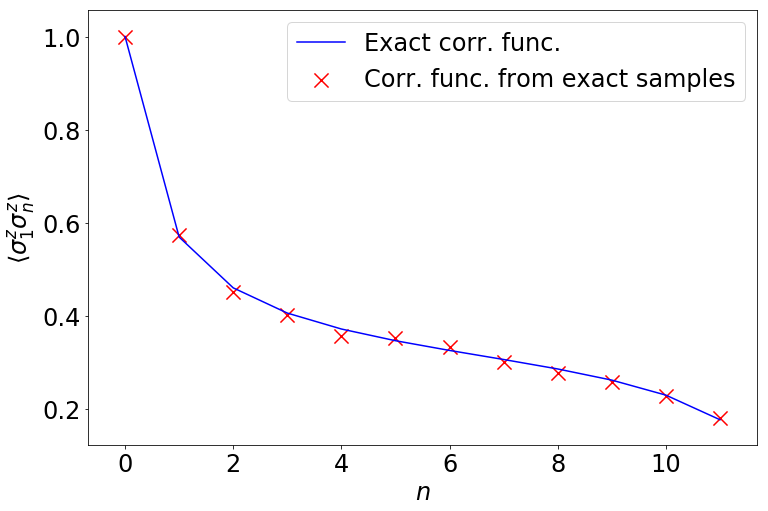

In [5]:
filehandler = open("/content/gdrive/My Drive/small_model.obj", 'rb')
model = pickle.load(filehandler)

samples = np.load("/content/gdrive/My Drive/small_rg_data_last.npy")
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{z}\sigma_n^{z}\rangle$')
plt.plot([model.corr(1, i, z, z) for i in range(1, 13)], 'b')
plt.scatter(np.arange(0, 12), [corr_from_samples(samples, 1, i, z, z) for i in range(1, 13)], marker='x', color='red', s=200)
plt.legend(['Exact corr. func.', 'Corr. func. from exact samples'])

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


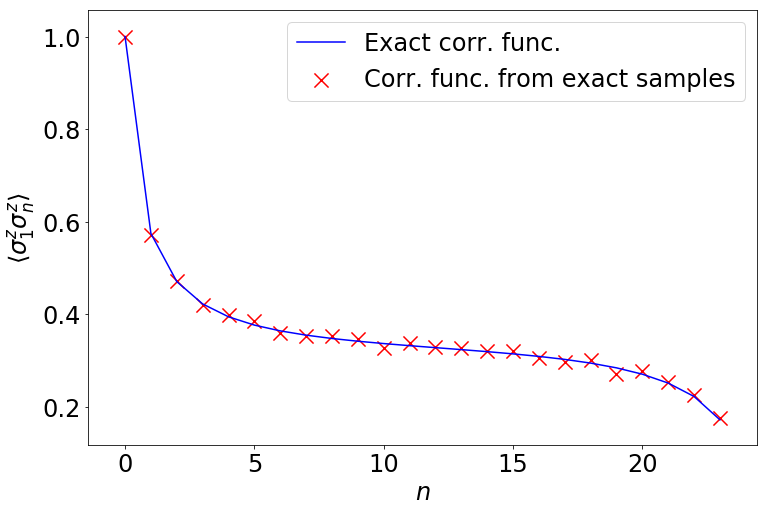

In [6]:
filehandler = open("/content/gdrive/My Drive/big_model.obj", 'rb') 
model_big = pickle.load(filehandler)

samples_big = np.load("/content/gdrive/My Drive/big_rg_data_last.npy")
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{z}\sigma_n^{z}\rangle$')
plt.plot([model_big.corr(1, i, z, z) for i in range(1, 25)], 'b')
plt.scatter(np.arange(0, 24), [corr_from_samples(samples_big, 1, i, z, z) for i in range(1, 25)], marker='x', color='red', s=200)
plt.legend(['Exact corr. func.', 'Corr. func. from exact samples'])

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


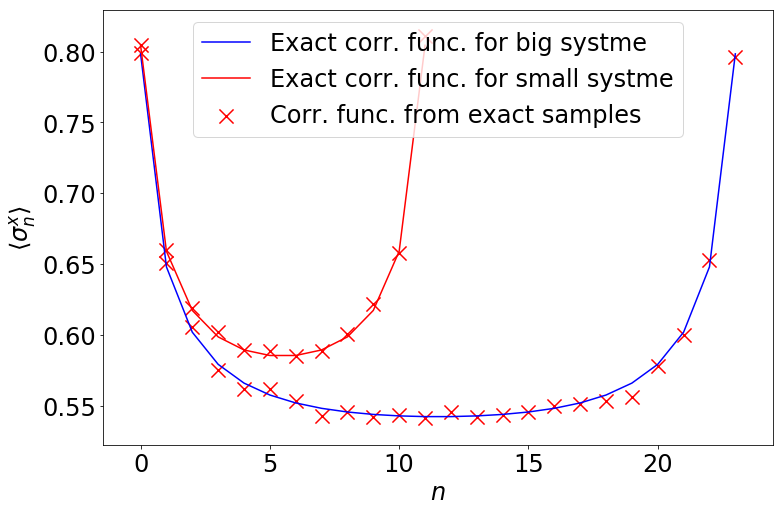

In [86]:
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_n^{x}\rangle$')
plt.plot([model_big.one_site_mean(i, x) for i in range(1, 25)], 'b')
plt.plot([model.one_site_mean(i, x) for i in range(1, 13)], 'r')
plt.scatter(np.arange(0, 24), [corr_from_samples(samples_big, 1, i, idm, x) for i in range(1, 25)], marker='x', color='red', s=200)
plt.scatter(np.arange(0, 12), [corr_from_samples(samples, 1, i, idm, x) for i in range(1, 13)], marker='x', color='red', s=200)
plt.legend(['Exact corr. func. for big systme', 'Exact corr. func. for small systme', 'Corr. func. from exact samples'])

#ResNet blocks for the encoder and decoder (under development)

In [0]:
import tensorflow as tf
import tensorflow.keras as K

def res_block_tr(inp, filters, ker_size):
    
    h0 = K.layers.Conv2DTranspose(filters=filters, kernel_size=(ker_size, 1), strides=1, padding='same', activation='elu')(inp)
    h1 = K.layers.Conv2DTranspose(filters=filters, kernel_size=(ker_size, 1), strides=1, padding='same', activation='elu')(h0)
    out = K.layers.Conv2DTranspose(filters=filters, kernel_size=(ker_size, 1), strides=1, padding='same', activation='elu')(h1)
    
    return out + h0
  
def res_block(inp, filters, ker_size):
    
    h0 = K.layers.Conv1D(filters=filters, kernel_size=ker_size, strides=1, padding='same', activation='elu')(inp)
    h1 = K.layers.Conv1D(filters=filters, kernel_size=ker_size, strides=1, padding='same', activation='elu')(h0)
    out = K.layers.Conv1D(filters=filters, kernel_size=ker_size, strides=1, padding='same', activation='elu')(h1)
    
    return out + h0

# Encoder and Decoder architecture

In [0]:
tf.reset_default_graph()

'''with tf.name_scope('decoder'):
    
    inp = K.Input(shape=(5,), dtype=tf.float32)
    h1 = K.layers.Dense(32, activation='elu')(inp)
    h2 = K.layers.Dense(64, activation='elu')(h1)
    
    h3 = K.layers.Reshape((1, 1, 64))(h2)
    h4 = K.layers.UpSampling2D(size=(5, 1))(h3)
    
    h5 = res_block_tr(h4, 64, 2)
    h6 = res_block_tr(h5, 32, 2)
    h7 = res_block_tr(h6, 32, 2)

    h8 = K.layers.UpSampling2D(size=(5, 1))(h7)
    
    h9 = res_block_tr(h8, 16, 3)
    h10 = res_block_tr(h9, 8, 3)
    h11 = res_block_tr(h10, 4, 3)
    
    out = K.layers.Reshape((25, 4))(h11)
    
    decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('encoder'):
    
    inp = K.Input(shape=(25, 4), dtype=tf.float32)
    
    h0 = res_block(inp, 4, 3)
    h1 = res_block(h0, 8, 3)
    h2 = res_block(h1, 16, 3)
    
    h3 = K.layers.MaxPool1D(pool_size=5)(h2)
    
    h4 = res_block(h3, 16, 2)
    h5 = res_block(h4, 32, 2)
    h6 = res_block(h5, 64, 2)
    
    h7 = K.layers.MaxPool1D(pool_size=5)(h6)
    h8 = K.layers.Reshape((64,))(h7)
    
    h9 = K.layers.Dense(64, activation='elu')(h8)
    h10 = K.layers.Dense(32, activation='elu')(h9)
    h11 = K.layers.Dense(10, activation=None)(h10)
    
    out = K.layers.Reshape((2, 5))(h11)
    encoder = K.Model(inputs=inp, outputs=out)'''

'''with tf.name_scope('decoder'):
    
    inp = K.Input(shape=(5,), dtype=tf.float32)
    h1 = K.layers.Dense(16, activation='elu')(inp)
    h2 = K.layers.Dense(32, activation='elu')(h1)
    
    h3 = K.layers.Reshape((1, 1, 32))(h2)
    h4 = K.layers.UpSampling2D(size=(5, 1))(h3)
    
    h5 = K.layers.Conv2DTranspose(filters=32, kernel_size=(2, 1), strides=1, padding='same', activation='elu')(h4)
    h6 = K.layers.Conv2DTranspose(filters=32, kernel_size=(2, 1), strides=1, padding='same', activation='elu')(h5)
    h7 = K.layers.Conv2DTranspose(filters=16, kernel_size=(2, 1), strides=1, padding='same', activation='elu')(h6)
    
    skip1 = K.layers.Conv2DTranspose(filters=16, kernel_size=(1, 1), strides=1, padding='same', activation='elu')(h4)
    
    h8 = K.layers.UpSampling2D(size=(5, 1))(h7 + skip1)
    
    h9 = K.layers.Conv2DTranspose(filters=16, kernel_size=(5, 1), strides=1, padding='same', activation='elu')(h8)
    h10 = K.layers.Conv2DTranspose(filters=16, kernel_size=(5, 1), strides=1, padding='same', activation='elu')(h9)
    h11 = K.layers.Conv2DTranspose(filters=4, kernel_size=(5, 1), strides=1, padding='same', activation=None)(h10)
    
    skip2 = K.layers.Conv2DTranspose(filters=4, kernel_size=(1, 1), strides=1, padding='same', activation='elu')(h8)
    
    out = K.layers.Reshape((25, 4))(h11 + skip2)
    decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('encoder'):
    
    inp = K.Input(shape=(25, 4), dtype=tf.float32)
    h0 = K.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same', activation='elu')(inp)
    h1 = K.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same', activation='elu')(h0)
    h2 = K.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same', activation='elu')(h1)
    
    skip1 = K.layers.Conv1D(filters=16, kernel_size=1, strides=1, padding='same', activation='elu')(inp)
    
    h3 = K.layers.MaxPool1D(pool_size=5)(h2 + skip1)
    
    h4 = K.layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='elu')(h3)
    h5 = K.layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='elu')(h4)
    h6 = K.layers.Conv1D(filters=32, kernel_size=2, strides=1, padding='same', activation='elu')(h5)
    
    skip2 = K.layers.Conv1D(filters=32, kernel_size=1, strides=1, padding='same', activation='elu')(h3)
    
    h7 = K.layers.MaxPool1D(pool_size=5)(h6 + skip2)
    h8 = K.layers.Reshape((32,))(h7)
    
    h9 = K.layers.Dense(32, activation='elu')(h8)
    h10 = K.layers.Dense(16, activation='elu')(h9)
    h11 = K.layers.Dense(10, activation=None)(h10)
    
    out = K.layers.Reshape((2, 5))(h11)
    encoder = K.Model(inputs=inp, outputs=out)'''

'''with tf.name_scope('decoder'):
    inp = K.Input(shape=(5,), dtype=tf.float32)
    
    h1 = K.layers.Dense(16, activation=None)(inp)
    h2 = K.layers.Dense(32, activation=None)(h1)
    h3 = K.layers.Dense(64, activation=None)(h2)
    h4 = K.layers.Dense(128, activation=None)(h3)
    h5 = K.layers.Dense(100, activation=None)(h4)
    
    skip = K.layers.Dense(100, activation=None)(inp)
    
    out = K.layers.Reshape((25, 4))(h5 + skip)
    decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('encoder'):
    inp = K.Input(shape=(25, 4), dtype=tf.float32)
    
    h0 = K.layers.Reshape((100,))(inp)
    h1 = K.layers.Dense(128, activation='elu')(h0)
    h2 = K.layers.Dense(64, activation='elu')(h1)
    h3 = K.layers.Dense(32, activation='elu')(h2)
    h4 = K.layers.Dense(16, activation='elu')(h3)
    h5 = K.layers.Dense(10, activation=None)(h4)
    
    skip = K.layers.Dense(10, activation=None)(h0)
    
    out = K.layers.Reshape((2, 5))(h5 + skip)
    encoder = K.Model(inputs=inp, outputs=out)'''

t = tf.placeholder_with_default(False, shape=(), name='trainable')

with tf.name_scope('decoder'):
    inp = K.Input(shape=(12,), dtype=tf.float32)
    
    h1 = K.layers.Dense(1024, activation=None, kernel_initializer='he_normal')(inp)
    '''h1 = K.layers.BatchNormalization(axis=1, momentum=0.99)(h1, training=t)'''
    h1 = K.layers.Activation('elu')(h1)
    
    '''h2 = K.layers.Dense(64, activation=None, kernel_initializer='he_normal')(h1)
    h2 = K.layers.BatchNormalization(axis=1, momentum=0.99)(h2, training=t)
    h2 = K.layers.Activation('elu')(h2)
    
    h3 = K.layers.Dense(64, activation=None, kernel_initializer='he_normal')(h2 + h1)
    h2 = K.layers.BatchNormalization(axis=1, momentum=0.99)(h2, training=t)
    h3 = K.layers.Activation('elu')(h3)
    
    h4 = K.layers.Dense(64, activation=None, kernel_initializer='he_normal')(h3)
    h2 = K.layers.BatchNormalization(axis=1, momentum=0.99)(h2, training=t)
    h4 = K.layers.Activation('elu')(h4)'''
    
    h5 = K.layers.Dense(48, activation=None, kernel_initializer='he_normal')(h1)
    
    out = K.layers.Reshape((12, 4))(h5)
    decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('encoder'):
    inp = K.Input(shape=(12, 4), dtype=tf.float32)
    
    h0 = K.layers.Reshape((48,))(inp)
    h0 = K.layers.Dense(1024, activation=None, kernel_initializer='he_normal')(h0)
    '''h0 = K.layers.BatchNormalization(axis=1, momentum=0.9)(h0, training=t)'''
    h0 = K.layers.Activation('elu')(h0)
    
    '''h1 = K.layers.Dense(64, activation=None, kernel_initializer='he_normal')(h0)
    h1 = K.layers.BatchNormalization(axis=1, momentum=0.9)(h1, training=t)
    h1 = K.layers.Activation('elu')(h1)
    
    h2 = K.layers.Dense(64, activation=None, kernel_initializer='he_normal')(h1 + h0)
    h1 = K.layers.BatchNormalization(axis=1, momentum=0.9)(h1, training=t)
    h2 = K.layers.Activation('elu')(h2)
    
    h3 = K.layers.Dense(64, activation=None, kernel_initializer='he_normal')(h2)
    h1 = K.layers.BatchNormalization(axis=1, momentum=0.9)(h1, training=t)
    h3 = K.layers.Activation('elu')(h3)'''
    
    h4 = K.layers.Dense(24, activation=None, kernel_initializer='he_normal')(h0)
    
    out = K.layers.Reshape((2, 12))(h4)
    encoder = K.Model(inputs=inp, outputs=out)

# Renormalization flow Encoder and Decoder architecture

In [64]:
with tf.name_scope('RG_decoder'):
    inp = K.Input(shape=(None, 4))
    h0 = K.layers.Reshape((-1, 1, 4))(inp)
    h1 = K.layers.UpSampling2D(size=(2, 1))(h0)
    h2 = K.layers.Conv2DTranspose(filters=64, kernel_size=(5, 1), strides=1, padding='same', activation=None, kernel_initializer='he_normal')(h1)
    h2 = K.layers.Activation("elu")(h2)
    h3 = K.layers.Conv2DTranspose(filters=4, kernel_size=(5, 1), strides=1, padding='same', activation=None, kernel_initializer='he_normal')(h2)
    out = K.layers.Reshape((-1, 4))(h3)
    
    rg_decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('RG_encoder'):
    inp = K.Input(shape=(None, 4))
    h1 = K.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(inp)
    h1 = K.layers.Activation("elu")(h1)
    h2 = K.layers.Conv1D(filters=4, kernel_size=5, strides=1, padding='same', activation=None, kernel_initializer='he_normal')(h1)
    out = K.layers.MaxPooling1D(pool_size=2)(h2)
    
    rg_encoder = K.Model(inputs=inp, outputs=out)

'''with tf.name_scope('RG_decoder'):
    inp = K.Input(shape=(25, 4))
    h0 = K.layers.Reshape((100,))(inp)
    h1 = K.layers.Dense(256, activation='elu')(h0)
    h2 = K.layers.Dense(200, activation=None)(h1)
    out = K.layers.Reshape((50, 4))(h2)
    
    rg_decoder = K.Model(inputs=inp, outputs=out)
    
with tf.name_scope('RG_encoder'):
    inp = K.Input(shape=(50, 4))
    h0 = K.layers.Reshape((200,))(inp)
    h1 = K.layers.Dense(256, activation='elu')(h0)
    h2 = K.layers.Dense(100, activation=None)(h1)
    out = K.layers.Reshape((25, 4))(h2)
    
    rg_encoder = K.Model(inputs=inp, outputs=out)'''

"with tf.name_scope('RG_decoder'):\n    inp = K.Input(shape=(25, 4))\n    h0 = K.layers.Reshape((100,))(inp)\n    h1 = K.layers.Dense(256, activation='elu')(h0)\n    h2 = K.layers.Dense(200, activation=None)(h1)\n    out = K.layers.Reshape((50, 4))(h2)\n    \n    rg_decoder = K.Model(inputs=inp, outputs=out)\n    \nwith tf.name_scope('RG_encoder'):\n    inp = K.Input(shape=(50, 4))\n    h0 = K.layers.Reshape((200,))(inp)\n    h1 = K.layers.Dense(256, activation='elu')(h0)\n    h2 = K.layers.Dense(100, activation=None)(h1)\n    out = K.layers.Reshape((25, 4))(h2)\n    \n    rg_encoder = K.Model(inputs=inp, outputs=out)"

# VAE

In [0]:
x_small = tf.placeholder(shape=(None, 12), dtype=tf.int32, name='x')
eps = tf.placeholder(shape=(None, 12), dtype=tf.float32, name='eps')
learning_rate = tf.placeholder(shape=(), dtype=tf.float32, name='lr')

with tf.name_scope('one_hot'):
    
    one_hot_x = tf.one_hot(x_small, axis=-1, depth=4)
    
with tf.name_scope('encode'):
    
    encoder_out = encoder(tf.cast(one_hot_x, dtype=tf.float32))
    mu = encoder_out[:, 0]
    log_s_sq = encoder_out[:, 1]
    
with tf.name_scope('decode'):
  
    log_probs = tf.nn.log_softmax(decoder(tf.sqrt(tf.exp(log_s_sq)) * eps + mu), axis=-1)
    
with tf.name_scope('loss'):
    
    loss = -tf.reduce_sum(one_hot_x * log_probs, axis=(1, 2))
    
with tf.name_scope('reg'):
    
    reg1 = 0.5 * tf.reduce_sum((tf.exp(log_s_sq) + mu ** 2), axis=-1)
    reg2 = -0.5 * tf.reduce_sum(log_s_sq + 1, axis=-1)
    
with tf.name_scope('full_loss'):
    
    full_loss = tf.reduce_mean(loss + reg2 + reg1)
    
with tf.name_scope('train'):
    
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(full_loss)
    
################################################################################

sample = tf.nn.log_softmax(decoder(eps), axis=-1)

In [0]:
x_big = tf.placeholder(shape=(None, 24), dtype=tf.int32, name='x_big')
eps_big = tf.placeholder(shape=(None, 12), dtype=tf.float32, name='eps_big')
learning_rate_big = tf.placeholder(shape=(), dtype=tf.float32, name='lr_big')

with tf.name_scope('one_hot_big'):
    
    one_hot_x_big = tf.one_hot(x_big, axis=-1, depth=4)
    
with tf.name_scope('encode_big'):
    
    encoder_out_big = encoder(rg_encoder(tf.cast(one_hot_x_big, dtype=tf.float32)))
    mu_big = encoder_out_big[:, 0]
    log_s_sq_big = encoder_out_big[:, 1]
    
with tf.name_scope('decode_big'):
  
    log_probs_big = tf.nn.log_softmax(rg_decoder(decoder(tf.sqrt(tf.exp(log_s_sq_big)) * eps_big + mu_big)), axis=-1)
    
with tf.name_scope('loss_big'):
    
    loss_big = -tf.reduce_sum(one_hot_x_big * log_probs_big, axis=(1, 2))
    
with tf.name_scope('reg_big'):
    
    reg1_big = 0.5 * tf.reduce_sum((tf.exp(log_s_sq_big) + mu_big ** 2), axis=-1)
    reg2_big = -0.5 * tf.reduce_sum(log_s_sq_big + 1, axis=-1)
    
with tf.name_scope('full_loss_big'):
    
    full_loss_big = tf.reduce_mean(loss_big + reg2_big + reg1_big)
    
with tf.name_scope('train_big'):
    
    train_step_big = tf.train.AdamOptimizer(learning_rate_big).minimize(full_loss_big, var_list=rg_decoder.weights + rg_encoder.weights)
    
################################################################################

sample_big = tf.nn.log_softmax(rg_decoder(decoder(eps_big)), axis=-1)

################################################################################

sample_super_res = tf.nn.log_softmax(rg_decoder(rg_decoder(decoder(eps_big))), axis=-1)

################################################################################

saver = tf.train.Saver()

#Initializing TF session

In [0]:
def batcher(data):
    
    np.random.shuffle(data)
    return [data[i * 100000:i * 100000 + 100000] for i in range(3)]

batch_size = 100000

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

#Uploding model from the google drive

In [14]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver.restore(sess, "/content/gdrive/My Drive/model.ckpt")

W0729 08:09:32.467734 140319174465408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


#Training VAE

In [0]:
losses = []
in_lr = 0.0001
f_lr = 0.00003
num_of_epochs = 1000
decay_coeff = (f_lr / in_lr) ** (1 / num_of_epochs)
for epoch in range(num_of_epochs):
    l_abs = 0
    for batch in batcher(samples):
        l, _ = sess.run([full_loss, train_step], feed_dict={x_small:batch, eps:np.random.randn(batch_size, 12), learning_rate:in_lr})
        l_abs = l_abs + l
        in_lr = in_lr * decay_coeff
    losses.append(l_abs)
    if epoch % 100 == 0:
        fig = plt.figure(figsize=(15, 8))
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.plot(losses[-100:])
        plt.show()
    
save_path = saver.save(sess, "/content/gdrive/My Drive/model.ckpt")

#Training RG VAE

In [0]:
losses_big = []
in_lr = 0.0001
f_lr = 0.00005
num_of_epochs = 1500
decay_coeff = (f_lr / in_lr) ** (1 / num_of_epochs)
for epoch in range(num_of_epochs):
    l_abs_big = 0
    for batch in batcher(samples_big):
        l, _ = sess.run([full_loss_big, train_step_big], feed_dict={x_big:batch,\
        eps_big:np.random.randn(batch_size, 12), learning_rate_big:in_lr})
        l_abs_big = l_abs_big + l
        in_lr = in_lr * decay_coeff
    losses_big.append(l_abs_big)
    if epoch % 100 == 0:
        fig = plt.figure(figsize=(15, 8))
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.plot(losses_big[-100:])
        plt.show()
    
save_path = saver.save(sess, "/content/gdrive/My Drive/model.ckpt")

#Sampling from VAE

In [0]:
probs = sess.run(sample, feed_dict={eps:np.random.randn(300000, 12)})
samples_learned = (probs + np.random.gumbel(size=(probs.shape))).argmax(-1)

probs_big = sess.run(sample_big, feed_dict={eps_big:np.random.randn(300000, 12)})
samples_learned_big = (probs_big + np.random.gumbel(size=(probs_big.shape))).argmax(-1)

#Plotting: exact corr. fucn. vs samples based (exact and VAE) corr. func.

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


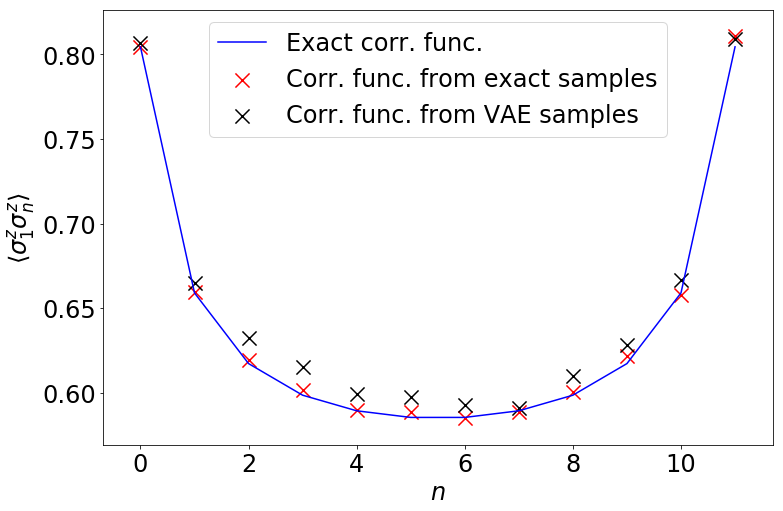

In [110]:
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{z}\sigma_n^{z}\rangle$')
'''plt.ylim(bottom=0)
plt.ylim(top=1)'''
plt.plot([model.corr(1, i, idm, x) for i in range(1, 13)], 'b')
plt.scatter(np.arange(0, 12), [corr_from_samples(samples, 1, i, idm, x) for i in range(1, 13)], marker='x', color='red', s=200)
plt.scatter(np.arange(0, 12), [corr_from_samples(samples_learned, 1, i, idm, x) for i in range(1, 13)], marker='x', color='black', s=200)
plt.legend(['Exact corr. func.', 'Corr. func. from exact samples', 'Corr. func. from VAE samples'])
plt.savefig('/content/gdrive/My Drive/corr_func.pdf')

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


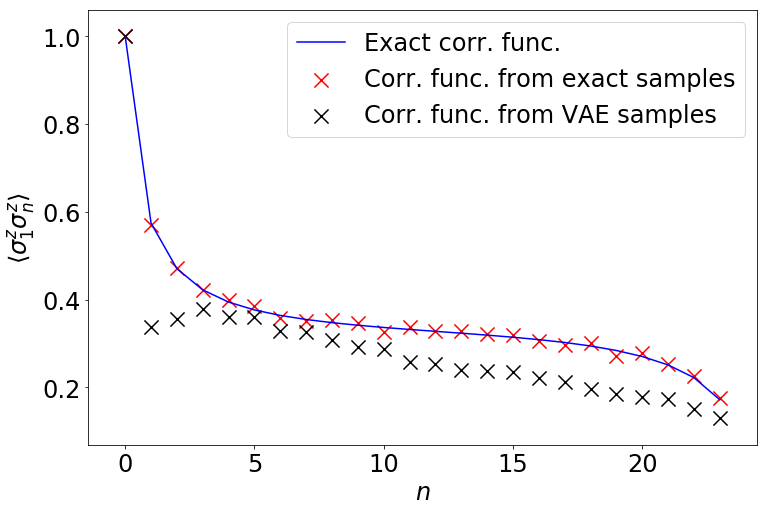

In [112]:
fig = plt.figure(figsize=(12, 8))
plt.xlabel(r'$n$')
plt.ylabel(r'$\langle\sigma_1^{z}\sigma_n^{z}\rangle$')
'''plt.ylim(bottom=0)
plt.ylim(top=1)'''
plt.plot([model_big.corr(1, i, z, z) for i in range(1, 25)], 'b')
plt.scatter(np.arange(0, 24), [corr_from_samples(samples_big, 1, i, z, z) for i in range(1, 25)], marker='x', color='red', s=200)
plt.scatter(np.arange(0, 24), [corr_from_samples(samples_learned_big, 1, i, z, z) for i in range(1, 25)], marker='x', color='black', s=200)
plt.legend(['Exact corr. func.', 'Corr. func. from exact samples', 'Corr. func. from VAE samples'])
plt.savefig('/content/gdrive/My Drive/corr_func_big.pdf')

#Below parts under development

In [0]:
probs = sess.run(sample_super_res, feed_dict={eps_big:np.random.randn(100000, 12)})
samples_super_res = (probs + np.random.gumbel(size=(probs.shape))).argmax(-1)

In [101]:
model_bigest = ising_chain(48, ta=0.9, la=0.0000001)
model_bigest.gs()

/usr/local/lib/python3.6/dist-packages/mpnum/mparray.py:1859: ComplexWarning: Casting complex values to real discards the imaginary part
  res[pos_l:pos_l_new, ..., pos_r:pos_r_new] = lt


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


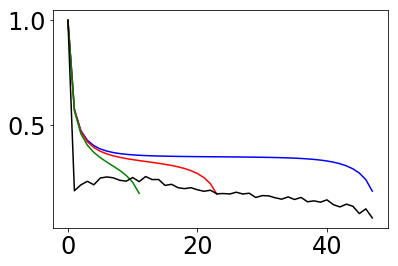

In [107]:
plt.plot([model_bigest.corr(1, i, z, z) for i in range(1, 49)], 'b')
plt.plot([model_big.corr(1, i, z, z) for i in range(1, 25)], 'r')
plt.plot([model.corr(1, i, z, z) for i in range(1, 13)], 'g')

plt.plot([corr_from_samples(samples_super_res, 1, i, z, z) for i in range(1, 49)], 'k')